# Análisis de Data No Estructurada - Llamadas (Presence)

## Librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re
import json
import os
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erivas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

Los datos empleados en este documento son una muestra de las conversaciones sostenidas mediantes llamadas telefónicas de los Agentes del Engagement Center con Leads. Estas llamadas fueron convertidas en texto (Speech to text) por el proveedor Presence.

In [2]:
# Open and read the xslx file
xlsx_data = 'D:/Proyectos/BOT - MVP/data/Conversaciones.xlsx'
conv   = pd.read_excel(xlsx_data)
conv

,RecID,Fecha,Servicio,Login,Agente,Telefono,CONTACTID,Tipo,inicio,fin,autor,conversacion
0,1709010.0,27/10/2024 03:13:13 p. m.,0.0,4111.0,Eduardo Juarez Pastrana,9.940664e+13,0.0,1.0,1.04,1.56,Cliente,Hola.
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,5.06,Agente,"Hola, ¿qué tal? Muy buenas tardes. Tengo un g..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.42,6.10,Cliente,Así es.
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.54,22.28,Agente,"Mucho gusto, señorita. Mi nombre es Eduardo P..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.75,23.47,Cliente,Así es.
...,...,...,...,...,...,...,...,...,...,...,...,...
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.22,67.44,Cliente,"Laura, déjale así, por favor."
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.32,68.96,Agente,"Laura. Ah, excelente, Laura."
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.44,72.12,Cliente,"Gracias, gracias, buen día."
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.46,71.16,Agente,"No, para servirte, buen día. Hasta luego."


In [3]:
conversaciones = conv[['RecID','autor', 'conversacion']]
cantidad_lead = conversaciones[conversaciones['autor'] == 'Cliente']
cantidad_agente = conversaciones[conversaciones['autor'] == 'Agente']
print('Cantidad de conversaciones del Cliente: ' + str(cantidad_lead.shape[0]))
print('Cantidad de conversaciones del Agente: ' + str(cantidad_agente.shape[0]))

Cantidad de conversaciones del Cliente: 28
Cantidad de conversaciones del Agente: 80


In [4]:
dialogos = conversaciones.pivot(columns='autor', values='conversacion')
dialogos

autor,Agente,Cliente
0,NaN,Hola.
1,"Hola, ¿qué tal? Muy buenas tardes. Tengo un g...",NaN
2,NaN,Así es.
3,"Mucho gusto, señorita. Mi nombre es Eduardo P...",NaN
4,NaN,Así es.
...,...,...
103,NaN,"Laura, déjale así, por favor."
104,"Laura. Ah, excelente, Laura.",NaN
105,NaN,"Gracias, gracias, buen día."
106,"No, para servirte, buen día. Hasta luego.",NaN


## Limpieza y Tokenización


El proceso de limpieza de texto, dentro del ámbito de text mining, consiste en eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido. No existe una única forma de hacerlo, depende en gran medida de la finalidad del análisis y de la fuente de la que proceda el texto. Por ejemplo, en las redes sociales, los usuarios pueden escribir de la forma que quieran, lo que suele resultar en un uso elevado de abreviaturas y signos de puntuación. En este ejercicio, se procede a eliminar: patrones no informativos (urls de páginas web), signos de puntuación, etiquetas HTML, caracteres sueltos y números.

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por unidad el elemento más sencillo con significado propio para el análisis en cuestión, en este caso, las palabras.

Existen múltiples librerías que automatizan en gran medida la limpieza y tokenización de texto, por ejemplo, la clase feature_extraction.text.CountVectorizer de Scikit Learn, nltk.tokenize o spaCy. A pesar de ello, para este ejemplo, se define una función que, si bien está menos optimizada, tiene la ventaja de poder adaptarse fácilmente dependiendo del tipo de texto analizado.

In [5]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [6]:
# Se aplica la función de limpieza y tokenización a cada conversación
# ==============================================================================
conversaciones['texto_tokenizado'] = conversaciones['conversacion'].apply(lambda x: limpiar_tokenizar(x))
conversaciones[['conversacion', 'texto_tokenizado']].head()

,conversacion,texto_tokenizado
0,Hola.,[hola]
1,"Hola, ¿qué tal? Muy buenas tardes. Tengo un g...","[hola, ¿qué, tal, muy, buenas, tardes, tengo, ..."
2,Así es.,"[así, es]"
3,"Mucho gusto, señorita. Mi nombre es Eduardo P...","[mucho, gusto, señorita, mi, nombre, es, eduar..."
4,Así es.,"[así, es]"


Gracias a la característica de los *dataframe* de pandas de poder contener cualquier tipo de elemento en sus columnas (siempre que sea el mismo para toda la columna), se puede almacenar el texto tokenizado. Cada elemento de la columna *texto_tokenizado* es una lista que contiene los tokens generados.

De nuevo matizar que, para casos productivos, es preferible emplear los tokenizadores de Scikit Learn, nltk o spaCy.

## Análisis Exploratorio

A la hora de entender que caracteriza la escritura de cada autor, es interesante estudiar qué palabras emplea, con qué frecuencia, así como el significado de las mismas.

En Python, una de las estructuras que más facilita el análisis exploratorio es el DataFrame de Pandas, que es la estructura en la que se encuentra almacenada ahora la información de los diálogos. Sin embargo, al realizar la tokenización, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran las conversaciones, y cada uno se encontraba en una fila, cumplimento así la condición de tidy data: una observación, una fila. Al realizar la tokenización, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo así la condición de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansión o unnest.

Aunque puede parecer un proceso poco eficiente (el número de filas aumenta mucho), este simple cambio facilita actividades de tipo: agrupación, contaje, gráficos...

In [7]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
conversaciones_tidy = conversaciones.explode(column='texto_tokenizado')
conversaciones_tidy = conversaciones_tidy.drop(columns='conversacion')
conversaciones_tidy = conversaciones_tidy.rename(columns={'texto_tokenizado':'token'})
conversaciones_tidy[['autor','token']].head(5)

,autor,token
0,Cliente,hola
1,Agente,hola
1,Agente,¿qué
1,Agente,tal
1,Agente,muy


### Frecuencia de Palabras

In [8]:
# Palabras totales utilizadas por cada autor
# ==========================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
conversaciones_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
Agente     1009
Cliente     195
Name: token, dtype: int64

In [9]:
# Palabras distintas utilizadas por cada autor
# ============================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
conversaciones_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
Agente     403
Cliente    114
Name: token, dtype: int64

### Longitud Media de las Conversaciones

In [10]:
# Longitud media y desviación de las conversaciones de cada autor
# ===============================================================
df_mediciones = pd.DataFrame(conversaciones_tidy.groupby(by='autor')['token'].count())
df_mediciones = df_mediciones.reset_index(drop=False)
total_conversaciones_agente = cantidad_agente.shape[0]
total_conversaciones_lead = cantidad_lead.shape[0]
total_palabras_agente = df_mediciones['token'][0]
total_palabras_lead = df_mediciones['token'][1]
media_conversaciones_agente = round(total_palabras_agente/total_conversaciones_agente,2)
media_conversaciones_lead = round(total_palabras_lead/total_conversaciones_lead,2)

print('La longitud media de las conversaciones del Cliente es: ' + str(media_conversaciones_agente))
print('La longitud media de los conversaciones del Lead es: ' + str(media_conversaciones_lead))

La longitud media de las conversaciones del Cliente es: 12.61
La longitud media de los conversaciones del Lead es: 6.96


### Palabras más utilizadas por autor

In [11]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
conversaciones_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                            
Agente  95    Agente    de     46
        309   Agente   que     34
        118   Agente    el     24
        120   Agente    en     24
        123   Agente    es     21
Cliente 478  Cliente    no     15
        504  Cliente    sí      8
        422  Cliente  como      5
        475  Cliente   más      4
        439  Cliente    es      4

### Stop words

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Ha estas palabras se les conoce como stopwords. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el término amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un análisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [12]:
# Obtención de listado de stopwords del español
# ==============================================================================
stop_words = list(stopwords.words('spanish'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe", "amalia", "ah", "ok", "amelia", "ah", "así", "arroba", "señorita", "sé", "gracias", "si"))
print(stop_words[:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


In [13]:
# Filtrado para excluir stopwords
# ==============================================================================
conversaciones_tidy = conversaciones_tidy[~(conversaciones_tidy["token"].isin(stop_words))]

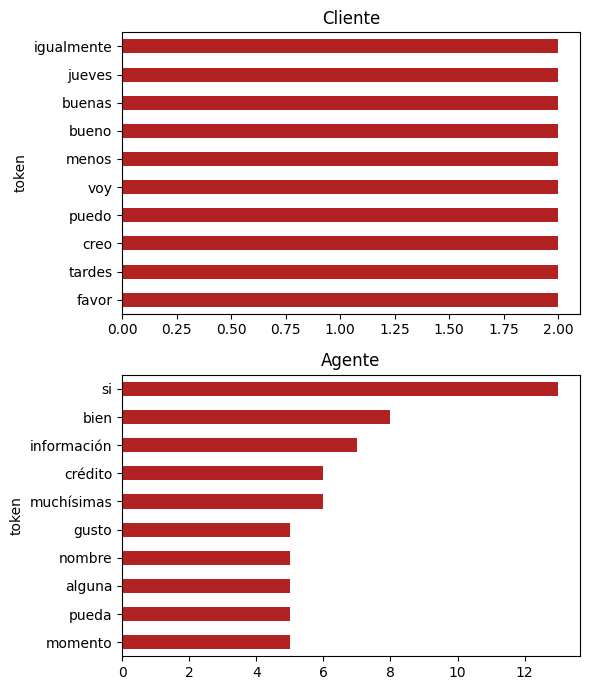

In [14]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 7))
for i, autor in enumerate(conversaciones_tidy.autor.unique()):
    df_temp = conversaciones_tidy[conversaciones_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

### Correlación entre autores

Una forma de cuantificar la similitud entre los perfiles de dos usuarios es calculando la correlación en el uso de palabras. La idea es que, si dos usuarios escriben de forma similar, tenderán a utilizar las mismas palabras y con frecuencias similares. La medida de similitud más utilizada al trabajar con texto es 1 - distancia coseno.

Para poder generar los estudios de correlación se necesita disponer de cada variable en una columna. En este caso, las variables a correlacionar son los autores.

In [15]:
# Pivotado de datos
# ==============================================================================
conversaciones_pivot = conversaciones_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
conversaciones_pivot.columns.name = None

In [16]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

conversaciones_pivot.corr(method=similitud_coseno)

,Agente,Cliente
Agente,1.000000,0.790495
Cliente,0.790495,1.000000


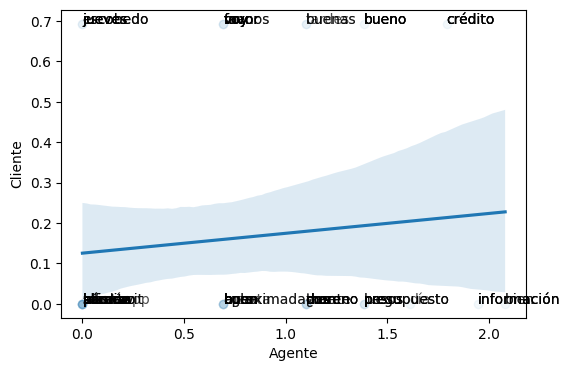

In [17]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(6, 4))
temp = conversaciones_pivot.dropna()
sns.regplot(
    x  = np.log(temp.Agente),
    y  = np.log(temp.Cliente),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.Agente[i]), np.log(temp.Cliente[i])),
        alpha = 0.7
    )

In [18]:
# Número de palabras comunes
# ==============================================================================
palabras_agente = set(conversaciones_tidy[conversaciones_tidy.autor == 'Agente']['token'])
palabras_cliente = set(conversaciones_tidy[conversaciones_tidy.autor == 'Cliente']['token'])

print(f"Palabras comunes entre Agente y Cliente: {len(palabras_agente.intersection(palabras_cliente))}")

Palabras comunes entre Agente y Cliente: 39


### Comparación en el uso de palabras

A continuación, se estudia qué palabras se utilizan de forma más diferenciada por cada usuario, es decir, palabras que utiliza mucho un autor y que no utiliza el otro. Una forma de hacer este análisis es mediante el log of odds ratio de las frecuencias. Esta comparación se hace por pares, en este caso se comparan Agente y Cliente.

Para realizar este cálculo es necesario que, para todos los usuarios, se cuantifique la frecuencia de cada una de las palabras que aparecen en el conjunto de conversaciones, es decir, si un autor no ha utilizado una de las palabras que sí ha utilizado otro, debe aparecer esa palabra en su registro con frecuencia igual a cero. Existen varias formas de conseguir esto, una de ellas es pivotar y despivotar el dataframe sustituyendo los NaN por cero.

In [19]:
# Cálculo del log of odds ratio de cada palabra (Agente vs Cliente)
# ==============================================================================
# Pivotaje y despivotaje
conversaciones_pivot = conversaciones_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

conversaciones_pivot = conversaciones_pivot.fillna(value=0)
conversaciones_pivot.columns.name = None

conversaciones_unpivot = conversaciones_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
conversaciones_unpivot = conversaciones_unpivot.reset_index()

# Selección de los autores elonmusk y mayoredlee
conversaciones_unpivot = conversaciones_unpivot[conversaciones_unpivot.autor.isin(['Agente', 'Cliente'])]

# Se añade el total de palabras de cada autor
conversaciones_unpivot = conversaciones_unpivot.merge(
                    conversaciones_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )

# Cálculo de odds y log of odds de cada palabra
conversaciones_logOdds = conversaciones_unpivot.copy()
conversaciones_logOdds['odds'] = (conversaciones_logOdds.n + 1) / (conversaciones_logOdds.N + 1)
conversaciones_logOdds = conversaciones_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
conversaciones_logOdds.columns.name = None

conversaciones_logOdds['log_odds']     = np.log(conversaciones_logOdds.Agente/conversaciones_logOdds.Cliente)
conversaciones_logOdds['abs_log_odds'] = np.abs(conversaciones_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como Agente/Cliente.
conversaciones_logOdds['autor_frecuente'] = np.where(conversaciones_logOdds.log_odds > 0,
                                              "Agente",
                                              "Cliente"
                                    )

In [20]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
conversaciones_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,Agente,Cliente,log_odds,abs_log_odds,autor_frecuente
token,,,,,
igualmente,0.001876,0.035714,-2.946317,2.946317,Cliente
creo,0.001876,0.035714,-2.946317,2.946317,Cliente
puedo,0.001876,0.035714,-2.946317,2.946317,Cliente
solicitaría,0.001876,0.023810,-2.540852,2.540852,Cliente
mitad,0.001876,0.023810,-2.540852,2.540852,Cliente
cuatro,0.001876,0.023810,-2.540852,2.540852,Cliente
decía,0.001876,0.023810,-2.540852,2.540852,Cliente
permítame,0.001876,0.023810,-2.540852,2.540852,Cliente
ay,0.001876,0.023810,-2.540852,2.540852,Cliente


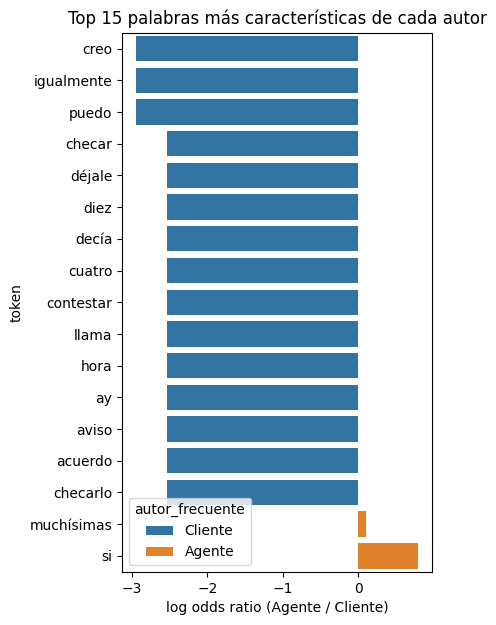

In [21]:
# Top 15 palabras más características de cada autor
# ==============================================================================

top_30 = conversaciones_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (Agente / Cliente)');

### Term Frequency e Inverse Document Frequency

Uno de los principales intereses en text mining, natural language processing e information retrieval es cuantificar la temática de un texto, así como la importancia de cada término que lo forma. Una manera sencilla de medir la importancia de un término dentro de un documento es utilizando la frecuencia con la que aparece (tf, term-frequency). Esta aproximación, aunque simple, tiene la limitación de atribuir mucha importancia a aquellas palabras que aparecen muchas veces aunque no aporten información selectiva. Por ejemplo, si la palabra matemáticas aparece 5 veces en un documento y la palabra página aparece 50, la segunda tendrá 10 veces más peso a pesar de que no aporte tanta información sobre la temática del documento. Para solucionar este problema se pueden ponderar los valores tf multiplicándolos por la inversa de la frecuencia con la que el término en cuestión aparece en el resto de documentos(idf). De esta forma, se consigue reducir el valor de aquellos términos que aparecen en muchos documentos y que, por lo tanto, no aportan información selectiva.

El estadístico tf-idf mide cómo de informativo es un término en un documento teniendo en cuenta la frecuencia con la que ese término aparece en otros documentos.

In [22]:
# Defining all the conditions inside a function
def condition(x):
    if x=='Cliente':
        return "0"
    else:
        return '1'

In [23]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = conversaciones_tidy.copy()
tf['id'] = tf['autor'].apply(condition)
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(5)

,id,token,count,total_count,tf
195,1,franco,1,532,0.00188
163,1,desvisitarnos,1,532,0.00188
164,1,diferencia,1,532,0.00188
165,1,directamente,1,532,0.00188
166,1,disponibilidad,1,532,0.00188


In [24]:
# Inverse document frequency
# ==============================================================================
idf = conversaciones_tidy.copy()
idf['id'] = idf['autor'].apply(condition)
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
331,si,13,-1.871802
39,bien,9,-1.504077
183,información,8,-1.386294


In [25]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,0,acuerdo,1,83,0.012048,1,0.693147,0.008351
51,0,perdón,1,83,0.012048,2,0.000000,0.000000
50,0,parece,1,83,0.012048,2,0.000000,0.000000
49,0,ocho,1,83,0.012048,1,0.693147,0.008351
48,0,número,1,83,0.012048,2,0.000000,0.000000


## Clasificación de Conversaciones

Para poder aplicar algoritmos de clasificación a un texto, es necesario crear una representación numérica del mismo. Una de las formas más utilizadas se conoce como Bag of Words. Este método consiste en identificar el set formado por todas las palabras (tokens) que aparecen en el corpus, en este caso el conjunto de todos los diálogos recuperados. Con este set se crea un espacio n-dimensional en el que cada dimensión (columna) es una palabra. Por último, se proyecta cada texto en ese espacio, asignando un valor para cada dimensión. En la mayoría de casos, el valor utilizado es el tf-idf.

En el siguiente apartado se construye un modelo de aprendizaje estadístico basado en máquinas de vector soporte (SVM) con el objetivo de predecir la autoría de los tweets. En concreto, se comparan los diálogos del Agente y el Lead.

Como modelo se emplea un SVM de Scikit-Learn. Para facilitar la obtención de la matriz TF-IDF se recurre a la clase TfidVectorized también de Scikit-Learn pero, en lugar de utilizar el tokenizador por defecto, se emplea el mismo definido en los apartados anteriores.

### Train-Test

En todo proceso de aprendizaje estadístico es recomendable repartir las observaciones en un set de entrenamiento y otro de test. Esto permite evaluar la capacidad del modelo. Para este ejercicio se selecciona como test un 20% aleatorio de los diálogos.

In [40]:
# Reparto train y test
# ==============================================================================
datos_X = conversaciones.loc[conversaciones.autor.isin(['Agente', 'Cliente']), 'conversacion']
datos_y = conversaciones.loc[conversaciones.autor.isin(['Agente', 'Cliente']), 'autor']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123   
)

In [27]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{'Agente': 75.5813953488372, 'Cliente': 24.41860465116279}
{'Agente': 68.18181818181819, 'Cliente': 31.818181818181817}


### Vectorización tf-idf

Empleando las conversaciones de entrenamiento se crea un matriz tf-idf en la que cada columna es un término, cada fila un documento y el valor de intersección el tf-idf correspondiente. Esta matriz representa el espacio n-dimensional en el que se proyecta cada tweet.

In [28]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [29]:
# Obtención de listado de stopwords del español
# ==============================================================================
stop_words = list(stopwords.words('spanish'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe", "amalia", "ah", "ok", "amelia"))

In [30]:
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizador.fit(X_train)

TfidfVectorizer(min_df=3,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                tokenizer=<function limpiar_tokenizar at 0x0000023D5ED57A60>)

In [31]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

In [32]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names_out())}")
print(tfidf_vectorizador.get_feature_names_out()[:10])

 Número de tokens creados: 39
['apoyar' 'aproximadamente' 'arroba' 'bien' 'buenas' 'bueno' 'ciudad'
 'comparte' 'crédito' 'día']


### Modelo SVM lineal

Como modelo de predicción se emplea un SVM. Para más información sobre cómo entrenar modelos de Scikit learn consultar Machine learning con Python y Scikit-learn.

In [33]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='linear')

In [34]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.000010,0.756209,0.016993,0.755840,0.004433
1,0.000077,0.756209,0.016993,0.755840,0.004433
2,0.000599,0.756209,0.016993,0.755840,0.004433
3,0.004642,0.756209,0.016993,0.755840,0.004433
4,0.035938,0.756209,0.016993,0.755840,0.004433
5,0.278256,0.756209,0.016993,0.755840,0.004433
8,129.154967,0.709150,0.053018,0.901194,0.010581
9,1000.000000,0.709150,0.053018,0.904092,0.011412
6,2.154435,0.696732,0.088716,0.845908,0.019819
7,16.681005,0.674510,0.045733,0.898252,0.009185


In [35]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 1e-05} : 0.7562091503267974 accuracy


In [36]:
# Error predicciones test
# ==============================================================================
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= ["Agente", "Cliente"],
             index = ["Agente", "Cliente"])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 22 clasificaciones: 7
% de error: 31.818181818181817

-------------------
Matriz de confusión
-------------------


,Agente,Cliente
Agente,15,0
Cliente,7,0


## Análisis de sentimientos

Una forma de analizar el sentimiento de un de un texto es considerando su sentimiento como la suma de los sentimientos de cada una de las palabras que lo forman. Esta no es la única forma de abordar el análisis de sentimientos, pero consigue un buen equilibrio entre complejidad y resultados.

In [37]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


### Sentimiento promedio de cada conversacion

Al disponer de los datos en formato tidy (una palabra por fila), mediante un inner join se añade a cada palabra su sentimiento y se filtran automáticamente todas aquellas palabras para las que no hay información disponible.

In [38]:
# Sentimiento promedio de cada tweet
# ==============================================================================
conversaciones_sentimientos = pd.merge(
                            left     = conversaciones_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )

conversaciones_sentimientos = conversaciones_sentimientos.drop(columns = "termino")
conversaciones_sentimientos['id'] = conversaciones_sentimientos['autor'].apply(condition)

# Se suman los sentimientos de las palabras que forman cada tweet.
conversaciones_sentimientos = conversaciones_sentimientos[["autor", "id", "sentimiento"]] \
                      .groupby(["autor", "id"])\
                      .sum().reset_index()
conversaciones_sentimientos.head()

,autor,id,sentimiento
0,Agente,1,4
1,Cliente,0,4


### Tweets positivos, negativos y neutros

Se calcula el porcentaje de tweets positivos, negativos y neutros para cada autor.

In [39]:
def perfil_sentimientos(df):
    print(autor)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")

for autor, df in conversaciones_sentimientos.groupby("autor"):
    perfil_sentimientos(df)

Agente
Positivos: 100.0
Neutros  : 0.0
Negativos: 0.0
 
Cliente
Positivos: 100.0
Neutros  : 0.0
Negativos: 0.0
 
